In [1]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np
import librosa
import scipy as sp

In [2]:
data_path = "../data/musicnet/musicnet/musicnet/train_data/"

In [3]:
rate, wav = wavfile.read(data_path + "1727.wav")

In [4]:
rate

44100

In [5]:
wav

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

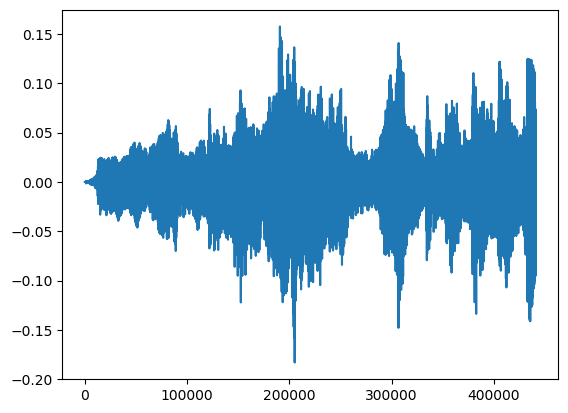

In [6]:
plt.plot(wav[0:rate*10])

In [7]:
n_fft = 2048
hop_length = 1024
mel = librosa.feature.melspectrogram(y=wav, sr=rate, n_fft=n_fft, hop_length=hop_length, fmax=8000)

In [8]:
mel_db = librosa.power_to_db(mel, ref=np.max)

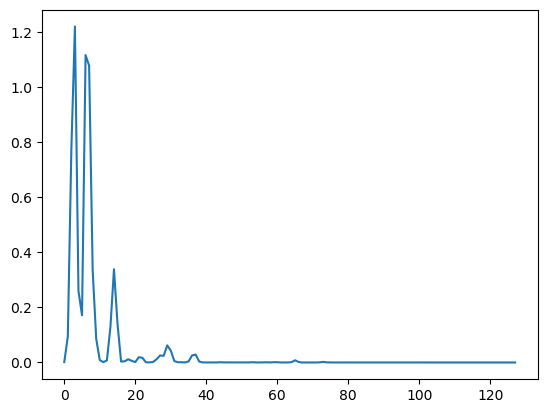

In [9]:
plt.plot(mel[:,102])

In [10]:
mel_db.shape

(128, 19254)

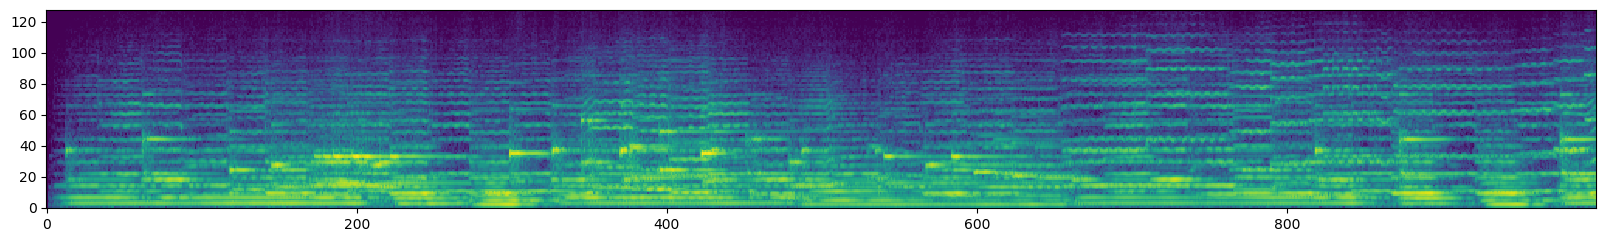

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(mel_db[:,:1000])
ax.invert_yaxis()

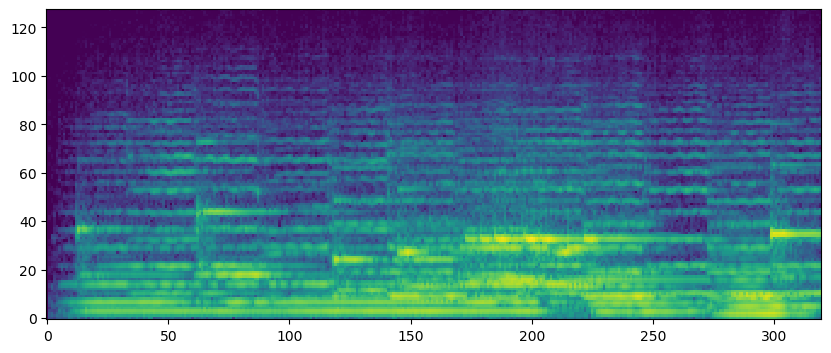

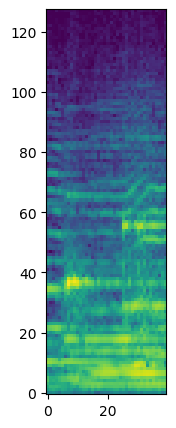

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(mel_db[:,0:320])
ax.invert_yaxis()
fig, ax = plt.subplots(figsize=(10,5))
plt.imshow(mel_db[:,320:360])
ax.invert_yaxis()

In [13]:
nmel_db = (mel_db + 80)/80

In [14]:
mel_db.shape

(128, 19254)

In [15]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader

from time import time
import copy, math

In [16]:
block_size = 320
pred_step = 40

In [17]:
class music_data():
    def __init__(self, data, block_size, pred_step):
        self.numpy = data.T
        self.block_size = block_size
        self.pred_step = pred_step
        self.shape = data.shape
        self.data = []
        
    def init_data(self):
        for i in range(self.shape[1] - self.block_size - self.pred_step):
            self.data.append((self.numpy[i:i+self.block_size], self.numpy[i+pred_step:i+self.block_size+pred_step]))
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [18]:
dataset = music_data(nmel_db, block_size, pred_step)
dataset.init_data()
batch_size=32

In [19]:
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

In [20]:
for i, batch in enumerate(dataloader):
    print(batch[0][0])
    print(batch[1][0])
    break

tensor([[0.4061, 0.4830, 0.5105,  ..., 0.0000, 0.0464, 0.0000],
        [0.2728, 0.3833, 0.4391,  ..., 0.0000, 0.0461, 0.0370],
        [0.3561, 0.4440, 0.5002,  ..., 0.0112, 0.0292, 0.0337],
        ...,
        [0.3740, 0.4506, 0.4472,  ..., 0.0039, 0.0029, 0.0000],
        [0.3356, 0.4408, 0.4577,  ..., 0.0000, 0.0000, 0.0000],
        [0.3860, 0.4882, 0.5154,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[0.4005, 0.5860, 0.7969,  ..., 0.0379, 0.0361, 0.0946],
        [0.4160, 0.5584, 0.7750,  ..., 0.0118, 0.0405, 0.0462],
        [0.4045, 0.5746, 0.7812,  ..., 0.0598, 0.0433, 0.0411],
        ...,
        [0.3036, 0.5959, 0.7153,  ..., 0.0000, 0.0262, 0.0137],
        [0.3184, 0.6231, 0.7391,  ..., 0.0000, 0.0096, 0.0299],
        [0.2932, 0.6238, 0.7402,  ..., 0.0000, 0.0000, 0.0000]])


In [21]:
enc_layer = nn.TransformerEncoderLayer(128, 4, dim_feedforward=256, batch_first=True)

In [22]:
for i, batch in enumerate(dataloader):
    print(batch[0].shape)
    out = enc_layer(batch[0])
    print(out.shape)
    break

torch.Size([32, 320, 128])
torch.Size([32, 320, 128])


In [23]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [24]:
class MusicModel(nn.Module):
    def __init__(self, d_model, d_ff, h, N, device):
        super(MusicModel, self).__init__()
        self.d_model = d_model
        self.pe = PositionalEncoding(d_model, 0.1)
        self.transformer = nn.TransformerEncoder(\
            nn.TransformerEncoderLayer(\
            d_model, 
            h,
            dim_feedforward=d_ff,
            batch_first=True),
            N,
            norm=nn.LayerNorm(d_model)
            )
        self.sig = nn.Sigmoid()
        
        self.device = device
        self.to(device)
        
    def forward(self, x):
        x = self.pe(x)
        mask = self.get_mask(x.size(1)).to(self.device)
        x = self.transformer(x, mask=mask)
        return x
    
    def get_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask

In [25]:
model = MusicModel(128, 256, 4, 3, torch.device("cpu"))

In [26]:
for batch in dataloader:
    out = model(batch[0])
    break
out.shape

torch.Size([32, 320, 128])

In [27]:
out

tensor([[[-1.3378,  0.7140, -0.1967,  ..., -0.4768, -2.0236,  0.0552],
         [-1.8740,  0.3754,  0.0829,  ..., -0.7784, -1.8381, -0.7746],
         [-1.1227, -0.8597,  0.9026,  ...,  0.8356, -1.6993, -0.3708],
         ...,
         [ 0.5311, -0.4668, -0.8099,  ...,  1.0417, -0.5114,  0.5122],
         [-0.8250, -0.6489, -1.4928,  ...,  0.7914,  0.2424, -0.2857],
         [-1.2348,  0.8787, -0.2888,  ...,  0.8432, -0.8832, -0.0915]],

        [[-0.1017,  0.6263,  1.6873,  ..., -0.4455, -0.9548,  0.3285],
         [ 0.3977,  0.2853,  0.9054,  ...,  0.7070, -0.7462,  1.1128],
         [ 0.1796, -0.5432,  1.2862,  ...,  0.6747, -1.3574,  0.2800],
         ...,
         [ 0.3248, -1.3196, -1.3094,  ...,  1.3005, -0.1241, -0.0785],
         [-1.3742, -1.0615, -1.1883,  ...,  0.4696, -0.1390, -0.3420],
         [-1.3916, -0.3050, -0.9511,  ...,  1.8633, -0.8323,  0.6953]],

        [[ 0.3180,  1.2636, -0.6164,  ...,  0.3320, -1.6093, -0.3970],
         [ 0.6888,  1.3138,  0.7311,  ..., -0

In [28]:
crit = nn.MSELoss()

In [29]:
crit(out, batch[1])

tensor(1.1743, grad_fn=<MseLossBackward0>)

In [30]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        self.optimizer.zero_grad()
        
def get_std_opt(model, warmup):
    return NoamOpt(model.d_model, 2, warmup,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [31]:
len(dataset) / batch_size

590.4375

In [32]:
d_model = 128
d_ff = 256
h = 4
N = 3
device = torch.device('cuda')

In [33]:
model = MusicModel(d_model, d_ff, h, N, device)
crit = nn.MSELoss()
optimizer = get_std_opt(model, 1000)

In [34]:
model.train()
for e in range(20):
    for i, (x, y) in enumerate(dataloader):
        x = x.to(device)
        pred = model(x)
        loss = crit(pred, y.to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        if i % 100 == 0:
            print(loss.item())
    print(e)

1.1842011213302612
0.7259874939918518
0.5115063786506653
0.24647827446460724
0.06968418508768082
0.01606643944978714
0
0.014239870011806488
0.014278416521847248
0.013102796860039234
0.013603952713310719
0.012671703472733498
0.01110053714364767
1
0.011006182990968227
0.01061916258186102
0.010399307124316692
0.009425707161426544
0.008799727074801922
0.00883449800312519
2
0.008665631525218487
0.007888266816735268
0.008126923814415932
0.007700629066675901
0.007628807332366705
0.0076047079637646675
3
0.007182827685028315
0.006993998773396015
0.006710148882120848
0.006875821854919195
0.006409906782209873
0.00665159011259675
4
0.0064937337301671505
0.00659471470862627
0.006000898778438568
0.0060878936201334
0.006056997925043106
0.006010591518133879
5
0.005872253328561783
0.006089992355555296
0.0060648806393146515
0.005786885041743517
0.0055671813897788525
0.0058017331175506115
6
0.005629184655845165
0.0055938283912837505
0.005672713275998831
0.005487796850502491
0.005361838266253471
0.0052225

In [35]:
model.eval()
model.to(device)
for (x, y) in dataloader:
    x = x.to(device)
    pred = model(x)
    break

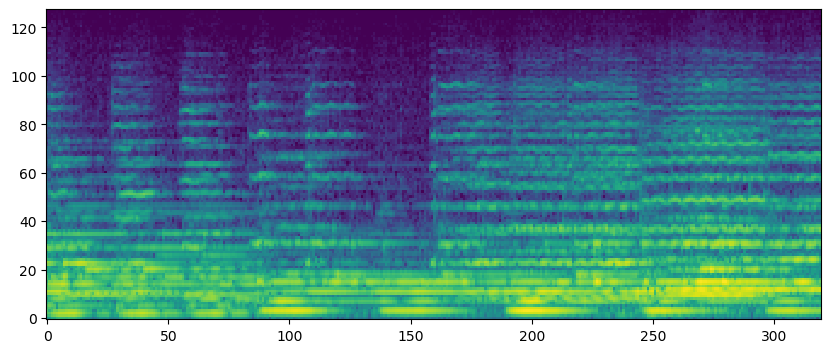

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(x[0].cpu().numpy().T)
ax.invert_yaxis()

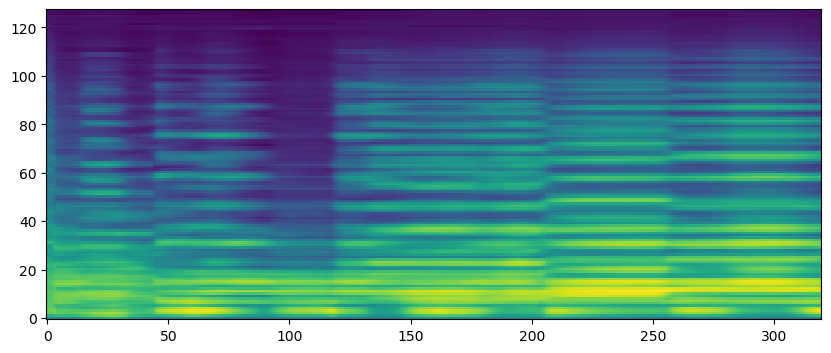

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(pred[0].detach().cpu().numpy().T)
ax.invert_yaxis()

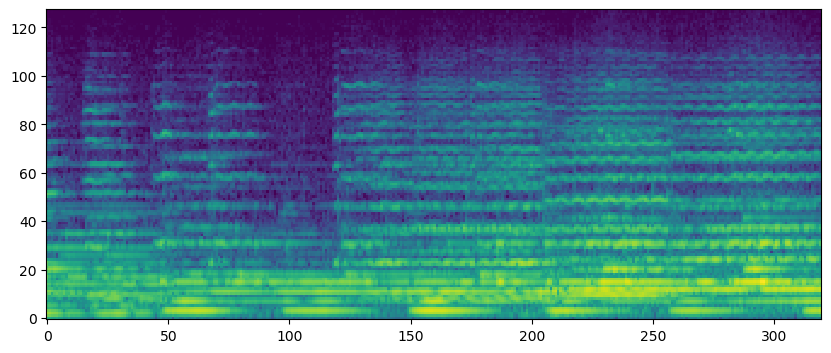

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(y[0].numpy().T)
ax.invert_yaxis()

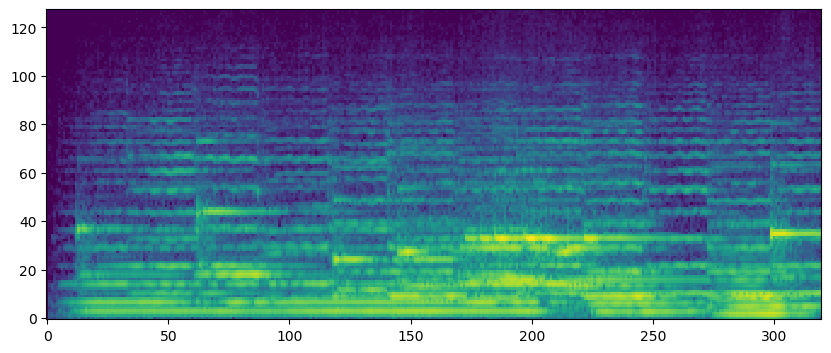

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(dataset.data[0][0].T)
ax.invert_yaxis()

In [40]:
x0 = torch.tensor(dataset.data[0][0]).unsqueeze(0)

In [41]:
model.eval()
x = torch.clone(x0).to(device)
total = torch.clone(x0)
with torch.no_grad():
    for i in range(100):
        out = model(x)
        total = torch.cat([total, out[:,-pred_step:].cpu()], dim=1)
        x = torch.clone(total[:, -block_size:, :]).to(device)

In [42]:
total.shape

torch.Size([1, 4320, 128])

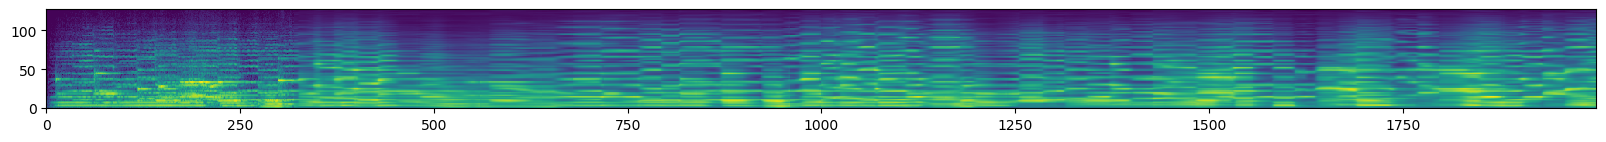

In [43]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(total[0].detach().cpu().numpy().T[:,:2000])
ax.invert_yaxis()

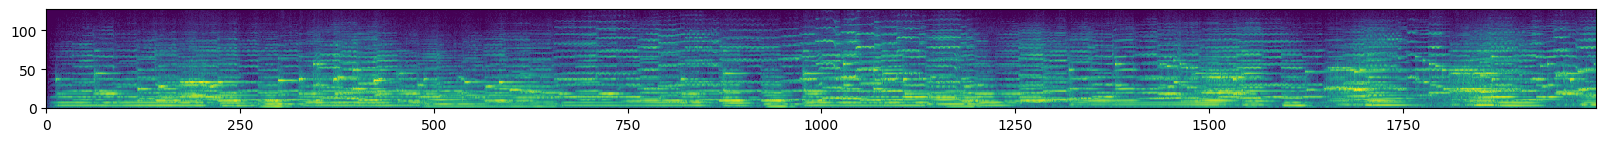

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(mel_db[:,:2000])
ax.invert_yaxis()

In [45]:
mel_db_out = total[0].detach().cpu().numpy().T
mel_db_out = mel_db_out * 80 - 80

In [46]:
mel_out = librosa.db_to_power(mel_db_out)

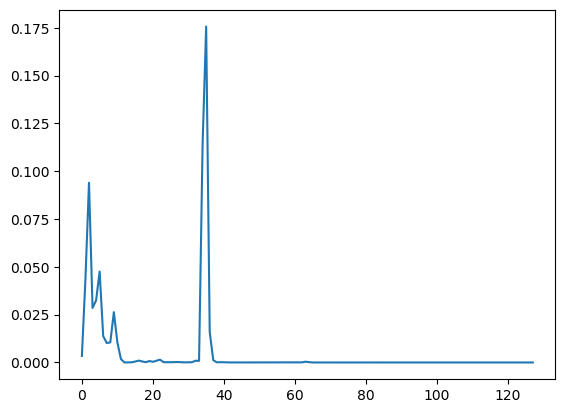

In [47]:
plt.plot(mel_out[:,300])

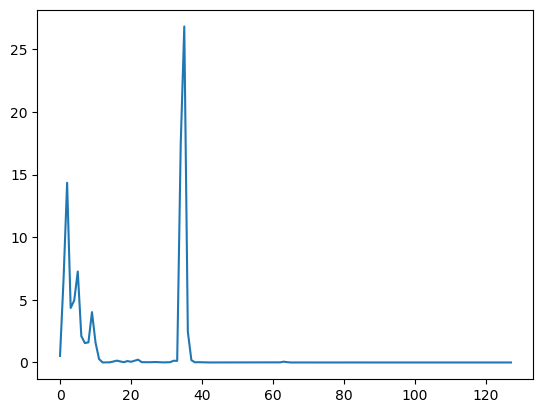

In [48]:
plt.plot(mel[:,300])

In [49]:
mel_out.shape, mel.shape

((128, 4320), (128, 19254))

In [50]:
wav_out = librosa.feature.inverse.mel_to_audio(mel_out, sr=rate, hop_length=hop_length, fmax=8000)

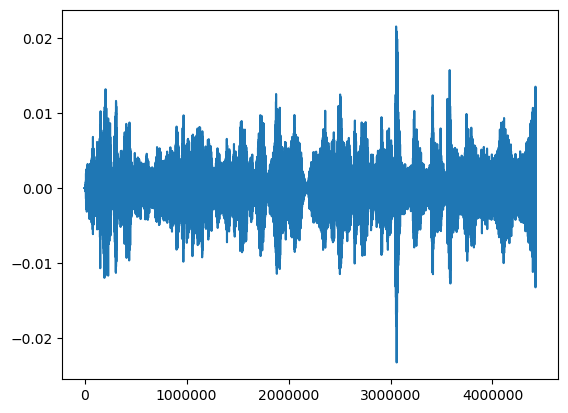

In [51]:
plt.plot(wav_out)

In [52]:
sp.io.wavfile.write("out.wav", rate, wav_out)